In [1]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "C:\\Users\\user\Downloads\enron"

# store all the fullpath of files in the root directory
file_names = []

# only store files size bigger than 5K
for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        if(stat(fullpath).st_size >= 5000):
            file_names.append(fullpath)

In [67]:
upload_files = random.sample(file_names, k = 1000) # no repeat
check_files = random.choices(file_names, k = 200)

In [68]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []

In [69]:
def upload_file(upload_list, chunk_size):
    for file in upload_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
#         cloud_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        cloud_hash.extend(text_hash)
        
def check_file(check_list, chunk_size):
    for file in check_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
            
        if(len(text_chunk) % 2 != 0):
            rand_chunk = text_chunk[random.randint(0, len(text_chunk) - 1)]
            text_chunk.append(rand_chunk)
#         check_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        check_hash.extend(text_hash)

In [70]:
def set_response_list(dirty_percent):
    dirty_chunks = random.sample(cloud_hash, k = int(dirty_percent * len(cloud_hash)))
    
    for chunk in dirty_chunks:
        status = random.randint(1, 2)
        response = random.randint(1, 2)
        if response is 1:    # if one response is 1, the other must be 2
            response_list[chunk] = {status: response}
            if status is 1:
                response_list[chunk][2] = 2
            else:
                response_list[chunk][1] = 2
        elif random.random() >= 0.5:    # half of the chance that the response list is complete
            if status is 1:
                response_list[chunk][2] = random.randint(1, 2)
            else:
                response_list[chunk][1] = random.randint(1, 2)

def query():    # return upload_amount
    query_list = check_hash.copy()
    query_list = list(set(query_list))    # dedup
    
    upload_amount = 0    # amount of chunks needed to be uploaded
    return_list = []
    
    not_fixed_0 = []    # not fixed and not exist
    not_fixed_1 = []    # not fixed and exist
    fixed_0_s1 = []    # fixed, not exist, response 1 in status 1
    fixed_0_s2 = []    # fixed, not exist, response 1 in status 2
    fixed_1_s1 = []    # fixed, exist, response 1 in status 1
    fixed_1_s2 = []    # fixed, exist, response 1 in status 2
    fixed_0_rand1 = []    # fixed, not exist, rare in status 1
    fixed_0_rand2 = []    # fixed, not exist, rare in status 2
    fixed_1_rand1 = []    # fixed, exist, rare in status 1
    fixed_1_rand2 = []    # fixed, exist, rare in status 2
    fixed_r2 = []    # fixed, all responses 2
    
    for h in query_list:    # categorize the chunks
        if (h not in response_list) and (h not in cloud_hash):    # not_fixed_0
            not_fixed_0.append(h)
        elif (h not in response_list) and (h in cloud_hash):    # not_fixed_1
            not_fixed_1.append(h)
        elif (h in response_list) and (h not in cloud_hash):
            if 1 in response_list[h].values():
                if list(response_list[h].values()).index(1) is 0:    # fixed_0_s1
                    fixed_0_s1.append(h)
                else:    # fixed_0_s2
                    fixed_0_s2.append(h)
            elif len(response_list[h].keys()) is 1:    # only 1 status in response_list
                if list(response_list[h].keys())[0] is 1:    # fixed_0_rand2
                    fixed_0_rand2.append(h)
                else:    # fixed_0_rand1
                    fixed_0_rand1.append(h)
            else:    # fixed_r2
                fixed_r2.append(h)
        else:
            if 1 in response_list[h].values():
                if list(response_list[h].values()).index(1) is 0:    # fixed_1_s1
                    fixed_1_s1.append(h)
                else:    # fixed_1_s2
                    fixed_1_s2.append(h)
            elif len(response_list[h].keys()) is 1:    # only 1 status in response_list
                if list(response_list[h].keys())[0] is 1:    # fixed_1_rand2
                    fixed_1_rand2.append(h)
                else:    # fixed_1_rand1
                    fixed_1_rand1.append(h)
            else:    # fixed_r2
                fixed_r2.append(h)
            
    while len(fixed_1_s1) > 0:    # status (1,0) return 1
        if len(fixed_0_s1) > 0:
            return_list.append(fixed_1_s1.pop())
            return_list.append(fixed_0_s1.pop())
            upload_amount += 1
            continue
        elif len(fixed_0_rand1) > 0:
            return_list.append(fixed_1_s1.pop())
            return_list.append(fixed_0_rand1.pop())
            upload_amount += 1
            continue
        elif len(not_fixed_0) > 0:
            return_list.append(fixed_1_s1.pop())
            return_list.append(not_fixed_0.pop())
            upload_amount += 1
            continue
        else:
            break
    
    while len(fixed_1_s2) > 0:    # status (1,1) return 1
        if len(fixed_1_s2) >= 2:
            return_list.append(fixed_1_s2.pop())
            return_list.append(fixed_1_s2.pop())
            upload_amount += 1
            continue
        if len(fixed_1_rand2) > 0:
            return_list.append(fixed_1_s2.pop())
            return_list.append(fixed_1_rand2.pop())
            upload_amount += 1
            continue
        elif len(not_fixed_1) > 0:
            return_list.append(fixed_1_s2.pop())
            return_list.append(not_fixed_1.pop())
            upload_amount += 1
            continue
        else:
            break
            
    while len(fixed_0_s1) > 0:    # status (1,0) return 1
        if len(fixed_1_s1) > 0:
            return_list.append(fixed_0_s1.pop())
            return_list.append(fixed_1_s1.pop())
            upload_amount += 1
            continue
        elif len(fixed_1_rand1) > 0:
            return_list.append(fixed_0_s1.pop())
            return_list.append(fixed_1_rand1.pop())
            upload_amount += 1
            continue
        elif len(not_fixed_1) > 0:
            return_list.append(fixed_0_s1.pop())
            return_list.append(not_fixed_1.pop())
            upload_amount += 1
            continue
        else:
            break
    
    while len(fixed_0_rand1) > 0:    # status (1,0) return RARE
        if len(fixed_1_rand1) > 0:
            return_list.append(fixed_0_rand1.pop())
            return_list.append(fixed_1_rand1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        elif len(not_fixed_1) > 0:
            return_list.append(fixed_0_rand1.pop())
            return_list.append(not_fixed_1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        else:
            break
    
    while len(fixed_1_rand1) > 0:    # status (1,0) return RARE
        if len(fixed_0_rand1) > 0:
            return_list.append(fixed_1_rand1.pop())
            return_list.append(fixed_0_rand1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        elif len(not_fixed_0) > 0:
            return_list.append(fixed_1_rand1.pop())
            return_list.append(not_fixed_0.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        else:
            break
    
    while len(fixed_1_rand2) > 0:    # status (1,1) return RARE
        if len(fixed_1_rand2) >= 2:
            return_list.append(fixed_1_rand2.pop())
            return_list.append(fixed_1_rand2.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        elif len(not_fixed_1) > 0:
            return_list.append(fixed_1_rand2.pop())
            return_list.append(not_fixed_1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        else:
            break
    
    while len(not_fixed_1) > 0:    # status (1,0) return RARE
        if len(fixed_0_rand1) > 0:
            return_list.append(not_fixed_1.pop())
            return_list.append(fixed_0_rand1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        elif len(not_fixed_0) > 0:
            return_list.append(not_fixed_1.pop())
            return_list.append(not_fixed_0.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        else:
            break
            
    while len(not_fixed_1) > 0:    # status (1,1) return RARE
        if len(fixed_1_rand2) > 0:
            return_list.append(not_fixed_1.pop())
            return_list.append(fixed_1_rand2.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        elif len(not_fixed_1) >= 2:
            return_list.append(not_fixed_1.pop())
            return_list.append(not_fixed_1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        else:
            break
            
    while len(not_fixed_0) > 0:    # status (1,0) return RARE
        if len(fixed_1_rand1) > 0:
            return_list.append(not_fixed_0.pop())
            return_list.append(fixed_1_rand1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        elif len(not_fixed_1) > 0:
            return_list.append(not_fixed_0.pop())
            return_list.append(not_fixed_1.pop())
            if random.random() >= 0.5:
                upload_amount += 2
            else:
                upload_amount += 1
            continue
        else:
            break
            
    remain_list = not_fixed_0 + not_fixed_1 + fixed_0_s1 + fixed_0_s2 + fixed_1_s1 + fixed_1_s2 + fixed_0_rand1 + fixed_0_rand2 + fixed_1_rand1 + fixed_1_rand2 + fixed_r2    # collect the remaining chunks
    while len(remain_list) > 1:    # return 2
        return_list.append(remain_list.pop())
        return_list.append(remain_list.pop())
        upload_amount += 2
    if len(remain_list) > 0:
        return_list.append(remain_list.pop())
        upload_amount += 1
        
    return upload_amount

In [71]:
def set_dirty_list(dirty_percent):
    dirty_list.extend(random.sample(cloud_hash, k = int(dirty_percent * len(cloud_hash))))

def rare():
    rare_list = check_hash.copy()
    if len(rare_list) % 2 != 0:
        rare_list.append(random.choice(rare_list))
    
    upload_amount = 0
    
    for i in range(0, len(rare_list), 2):
        if (rare_list[i] in dirty_list) or (rare_list[i+1] in dirty_list):
            upload_amount += 2
            continue
        elif (rare_list[i] in cloud_hash) or (rare_list[i+1] in cloud_hash):
            if random.random() >= 0.5:
                upload_amount += 1
            else:
                upload_amount += 2
            continue
        else:
            upload_amount += 2
            
    return upload_amount

def zeus():
    zeus_list = check_hash.copy()
    if len(zeus_list) % 2 != 0:
        zeus_list.append(random.choice(zeus_list))
        
    upload_amount = 0
    
    for i in range(0, len(zeus_list), 2):
        if (zeus_list[i] in dirty_list) or (zeus_list[i+1] in dirty_list):
            upload_amount += 2
            continue
        elif (zeus_list[i] not in cloud_hash) and (zeus_list[i+1] not in cloud_hash):
            upload_amount += 2
            continue
        else:
            upload_amount += 1
    
    return upload_amount

In [72]:
new_algo_cost = []
rare_cost = []
zeus_cost = []
chunk_amount = []

In [73]:
upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 22248
hash existence amount: 1276


In [74]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 11222
hash existence amount: 645


In [75]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 5710
hash existence amount: 311


In [76]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 2938
hash existence amount: 133


In [77]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 1576
hash existence amount: 58


In [78]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 862
hash existence amount: 30


In [79]:
import numpy as np

chunk_size = np.array([128, 256, 512, 1024, 2048, 4096])
new_algo_byte = np.multiply(np.array(new_algo_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
new_algo_upload_percentage = np.divide((np.array(new_algo_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_algo_cost, "new_algo_upload_percentage:", new_algo_upload_percentage, "new_algo_cost:", new_algo_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)

new_algo_upload_amount: [19976, 10151, 5170, 2676, 1393, 750] new_algo_upload_percentage: [89.7878461  90.45624666 90.54290718 91.08236896 88.38832487 87.00696056] new_algo_cost: [2556928 2598656 2647040 2740224 2852864 3072000]
rare_upload_amount: [21730, 10981, 5589, 2902, 1565, 854] rare_upload_percentage: [97.67170083 97.85243272 97.88091068 98.77467665 99.30203046 99.07192575] rare_cost: [2781440 2811136 2861568 2971648 3205120 3497984]
zeus_upload_amount: [21204, 10723, 5473, 2858, 1542, 845] zeus_upload_percentage: [95.30744337 95.55337729 95.84938704 97.27705922 97.84263959 98.02784223] zeus_cost: [2714112 2745088 2802176 2926592 3158016 3461120]


Text(0.5, 0.98, 'Comparison among New Algo., RARE, and ZEUS')

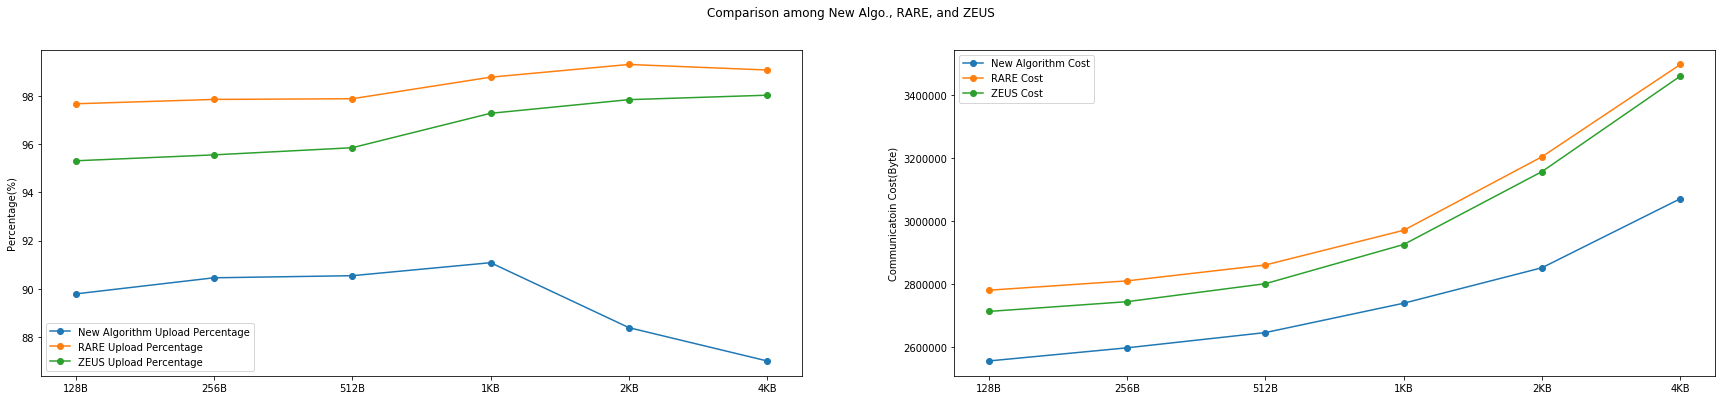

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (30, 6))
# plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
ax[0].plot(x, new_algo_upload_percentage, '-o', label = 'New Algorithm Upload Percentage')
ax[0].plot(x, rare_upload_percentage, '-o', label = 'RARE Upload Percentage')
ax[0].plot(x, zeus_upload_percentage, '-o', label = 'ZEUS Upload Percentage')
ax[0].legend()
ax[0].set_ylabel('Percentage(%)')

ax[1].plot(x, new_algo_byte, '-o', label = 'New Algorithm Cost')
ax[1].plot(x, rare_byte, '-o', label = 'RARE Cost')
ax[1].plot(x, zeus_byte, '-o', label = 'ZEUS Cost')
ax[1].set_ylabel('Communicatoin Cost(Byte)')
ax[1].legend()
fig.suptitle('Comparison among New Algo., RARE, and ZEUS')

# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, new_algo_upload_percentage, '-o', label = 'New Algorithm Upload Percentage')
# plt.plot(x, rare_upload_percentage, '-o', label = 'RARE Upload Percentage')
# plt.legend()
# plt.ylabel('Percentage(%)')
# plt.title('Comparison between New Algo. and RARE')
# plt.show()

In [81]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
new_algo_cost = []
rare_cost = []
zeus_cost = []
chunk_amount = []

set_response_list(0.1)
set_dirty_list(0.1)

upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 22248
hash existence amount: 1276


In [82]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 11222
hash existence amount: 645


In [83]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 5710
hash existence amount: 311


In [84]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 2938
hash existence amount: 133


In [85]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 1576
hash existence amount: 58


In [86]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.1)
set_dirty_list(0.1)
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 862
hash existence amount: 30


In [87]:
new_algo_byte = np.multiply(np.array(new_algo_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
new_algo_upload_percentage = np.divide((np.array(new_algo_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_algo_cost, "new_algo_upload_percentage:", new_algo_upload_percentage, "new_algo_cost:", new_algo_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)

new_algo_upload_amount: [19962, 10168, 5182, 2684, 1383, 741] new_algo_upload_percentage: [89.72491909 90.60773481 90.7530648  91.35466304 87.75380711 85.96287703] new_algo_cost: [2555136 2603008 2653184 2748416 2832384 3035136]
rare_upload_amount: [21743, 10981, 5595, 2894, 1558, 856] rare_upload_percentage: [97.73013305 97.85243272 97.98598949 98.50238257 98.85786802 99.30394432] rare_cost: [2783104 2811136 2864640 2963456 3190784 3506176]
zeus_upload_amount: [21202, 10722, 5473, 2857, 1541, 845] zeus_upload_percentage: [95.29845379 95.54446623 95.84938704 97.24302246 97.77918782 98.02784223] zeus_cost: [2713856 2744832 2802176 2925568 3155968 3461120]


Text(0.5, 0.98, 'Comparison among New Algo., RARE, and ZEUS')

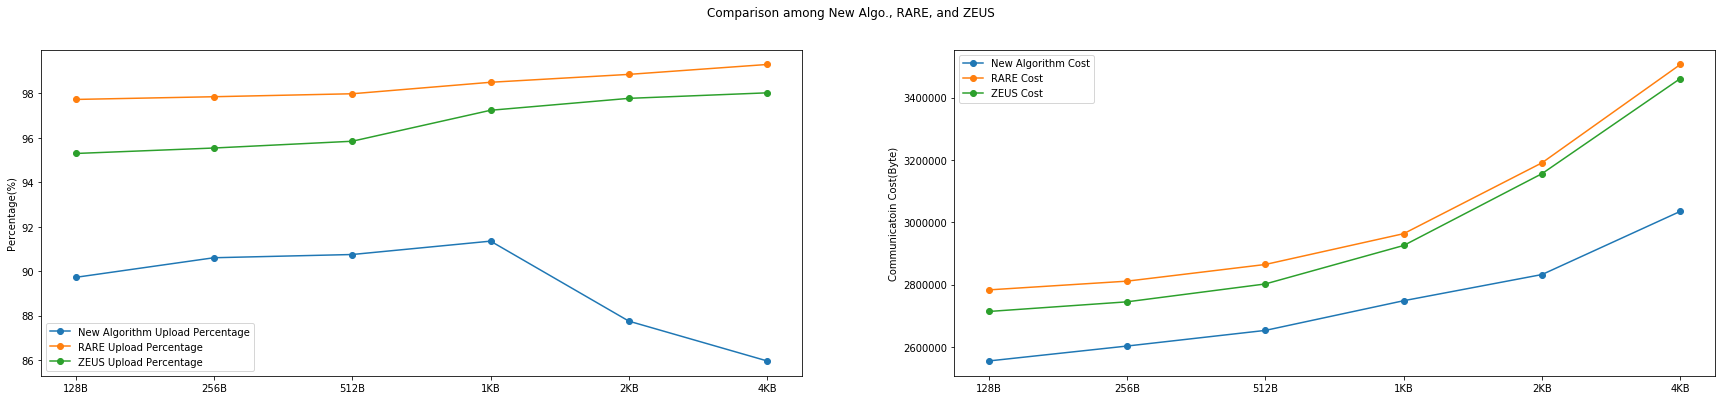

In [88]:
fig, ax = plt.subplots(1, 2, figsize = (30, 6))
# plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
ax[0].plot(x, new_algo_upload_percentage, '-o', label = 'New Algorithm Upload Percentage')
ax[0].plot(x, rare_upload_percentage, '-o', label = 'RARE Upload Percentage')
ax[0].plot(x, zeus_upload_percentage, '-o', label = 'ZEUS Upload Percentage')
ax[0].legend()
ax[0].set_ylabel('Percentage(%)')

ax[1].plot(x, new_algo_byte, '-o', label = 'New Algorithm Cost')
ax[1].plot(x, rare_byte, '-o', label = 'RARE Cost')
ax[1].plot(x, zeus_byte, '-o', label = 'ZEUS Cost')
ax[1].set_ylabel('Communicatoin Cost(Byte)')
ax[1].legend()
fig.suptitle('Comparison among New Algo., RARE, and ZEUS')

# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, new_algo_upload_percentage, '-o', label = 'New Algorithm Upload Percentage')
# plt.plot(x, rare_upload_percentage, '-o', label = 'RARE Upload Percentage')
# plt.legend()
# plt.ylabel('Percentage(%)')
# plt.title('Comparison between New Algo. and RARE')
# plt.show()

In [89]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
new_algo_cost = []
rare_cost = []
zeus_cost = []
chunk_amount = []

set_response_list(0.25)
set_dirty_list(0.25)

upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 22248
hash existence amount: 1276


In [90]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 11222
hash existence amount: 645


In [91]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 5710
hash existence amount: 311


In [92]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 2938
hash existence amount: 133


In [93]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 1576
hash existence amount: 58


In [94]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []
set_response_list(0.25)
set_dirty_list(0.25)
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_algo_cost.append(query())
rare_cost.append(rare())
zeus_cost.append(zeus())

check hash: 862
hash existence amount: 30


In [95]:
new_algo_byte = np.multiply(np.array(new_algo_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
new_algo_upload_percentage = np.divide((np.array(new_algo_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_algo_cost, "new_algo_upload_percentage:", new_algo_upload_percentage, "new_algo_cost:", new_algo_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)

new_algo_upload_amount: [19980, 10163, 5187, 2686, 1392, 749] new_algo_upload_percentage: [89.80582524 90.56317947 90.84063047 91.42273656 88.3248731  86.89095128] new_algo_cost: [2557440 2601728 2655744 2750464 2850816 3067904]
rare_upload_amount: [21731, 10976, 5595, 2893, 1560, 854] rare_upload_percentage: [97.67619561 97.80787738 97.98598949 98.46834581 98.98477157 99.07192575] rare_cost: [2781568 2809856 2864640 2962432 3194880 3497984]
zeus_upload_amount: [21205, 10723, 5470, 2857, 1542, 844] zeus_upload_percentage: [95.31193815 95.55337729 95.79684764 97.24302246 97.84263959 97.91183295] zeus_cost: [2714240 2745088 2800640 2925568 3158016 3457024]


Text(0.5, 0.98, 'Comparison among New Algo., RARE, and ZEUS')

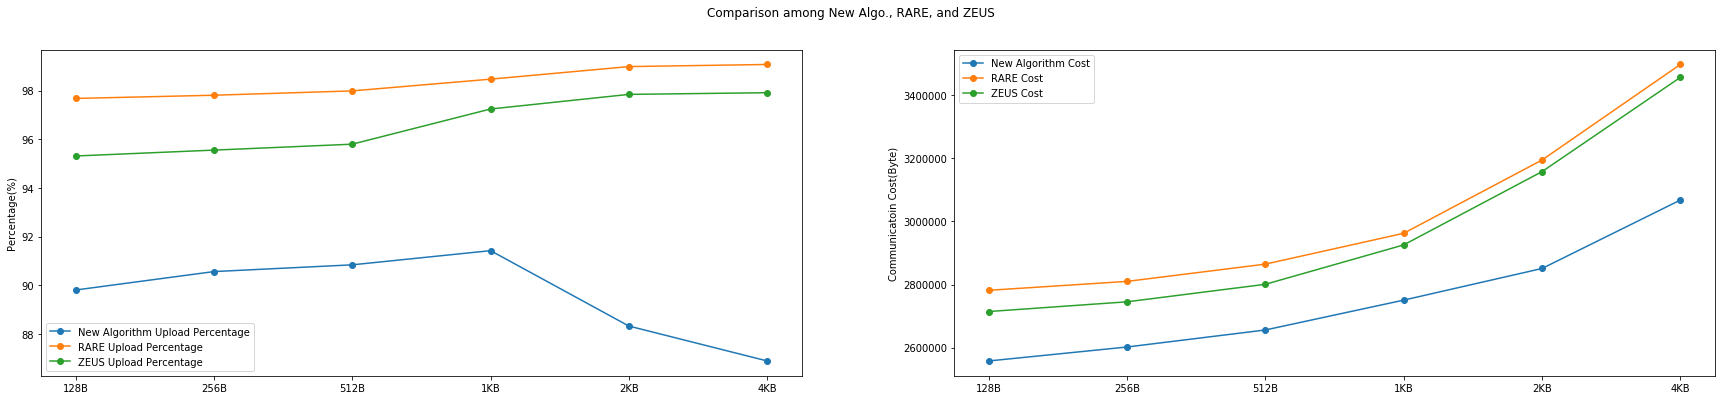

In [96]:
fig, ax = plt.subplots(1, 2, figsize = (30, 6))
# plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
ax[0].plot(x, new_algo_upload_percentage, '-o', label = 'New Algorithm Upload Percentage')
ax[0].plot(x, rare_upload_percentage, '-o', label = 'RARE Upload Percentage')
ax[0].plot(x, zeus_upload_percentage, '-o', label = 'ZEUS Upload Percentage')
ax[0].legend()
ax[0].set_ylabel('Percentage(%)')

ax[1].plot(x, new_algo_byte, '-o', label = 'New Algorithm Cost')
ax[1].plot(x, rare_byte, '-o', label = 'RARE Cost')
ax[1].plot(x, zeus_byte, '-o', label = 'ZEUS Cost')
ax[1].set_ylabel('Communicatoin Cost(Byte)')
ax[1].legend()
fig.suptitle('Comparison among New Algo., RARE, and ZEUS')

# plt.plot(x, new_algo_upload_percentage, '-o', label = 'New Algorithm Upload Percentage')
# plt.plot(x, rare_upload_percentage, '-o', label = 'RARE Upload Percentage')
# plt.legend()
# plt.ylabel('Percentage(%)')
# plt.title('Comparison between New Algo. and RARE')
# plt.show()